In [1]:
# Import statements (standard)
import os
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set_style("white")

# Import statements (custom)
import helper_functions as hf

# Import statements (ML)
from sklearn.preprocessing import StandardScaler

# Import statements (DL)
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential
from keras.models import load_model
from keras.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# Load data.
df = pd.read_csv('~/Desktop/Springboard/Cryptocurrency/code/cleaned_crypto_all_features.csv', header=[0,1], skiprows=[2], index_col=0)
df.index.name = 'time'
df.index = pd.to_datetime(df.index)
df = df[:-1].astype(float) # drop last row (missing closing prices)

### Forecasting with Non-Stationary Closing Prices

In [3]:
# Function to prepare samples.

def prepare_samples(df, window_size, train_ed):
    """
    Prepares samples for LSTM. 
    
    Inputs:
        df: dataframe that will be split into samples (train/test)
        window_size: length of each sample (24 for one day intervals)
        train_ed: end date for training set
    
    Returns:
        samples: samples ready to be inserted into LSTM (train/test)
        outputs: prices to be predicted (train/test)
        mean, var: training set mean/var for closing price (save for later)
    """
    train_df = df.ix[:train_ed]
    
    scl = StandardScaler()
    scl.fit(train_df)
    
    scl_arr = scl.transform(df)
    mean = scl.mean_[train_df.columns.get_loc('close')]
    var = scl.var_[train_df.columns.get_loc('close')]
    
    samples = []
    outputs = []
    
    for i in range(scl_arr.shape[0]-window_size):
        temp_sample = scl_arr[i:(i+window_size),:]
        if (i+window_size) < scl_arr.shape[0]:
            temp_output = scl_arr[(i+window_size),0]
        else:
            temp_output = np.nan
        samples.append(temp_sample)
        outputs.append(temp_output)
    
    n_train = len(train_df.index)
    train_samples = np.array(samples[:n_train])
    test_samples = np.array(samples[n_train:])
    train_outputs = np.array(outputs[:n_train])
    test_outputs = np.array(outputs[n_train:])
    
    return train_samples, test_samples, train_outputs, test_outputs, scl, mean, var

In [4]:
# Function to set up LSTM.

def build_model(inputs, n_units, activ_func="linear", dropout=0.2, loss="mae", optimizer="Nadam"):
    """
    Helper function to build LSTM.
    
    Inputs:
        inputs: matrix to be fed into the data frame (# samples, # of time steps, # of features) 
        n_units: length of prediction spit out (1 for one hour ahead)
        
    Returns:
        model: LSTM (ready to train!)
        
    """
    model = Sequential()

    model.add(LSTM(n_units[0], return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    
    model.add(LSTM(n_units[1], return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(units=n_units[2]))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [5]:
# Function to generate predictions for test set. 
# NOTE: Here, we use a "walk forward" approach in which the predictions output from our
#       LSTM become the inputs for subsequent time steps.

def pred_test_set(model, test_df, window_size, tr_mean, tr_var, wreal):
    """
    Generate predictions for test set using "walk forward" approach.
    
    Inputs:
        model: LSTM (fitted on training set)
        test_df: data frame containing all data needed for test set (easier to generate next sample this way)
        window_size: length of each sample (24 for one day intervals)
        tr_mean, tr_var: parameters from training set used to scale closing prices
        wreal: boolean value denoting whether one uses the forecasted/actual values when doing one step
               ahead forecasts for test set (True: actual, False: forecasted)
    
    Returns:
        test_preds: predicted closing prices (rescaled by mean, var)
    
    """
    test_preds = []
    
    for i in range(len(test_df.index)-window_size):
        temp_sample = test_df.iloc[i:(i+window_size),:].values
        sample_arr = np.reshape(temp_sample, (1,window_size,len(test_df.columns)))
        prediction = model.predict(sample_arr)
        
        if wreal:
            scaled_prediction = prediction * math.sqrt(tr_var) + tr_mean
            test_preds.append(float(scaled_prediction))
        else:
            # Replace value in test_df with prediction, append scaled prediction to test_preds.
            test_df.iat[(i+window_size),0] = prediction
            scaled_prediction = prediction * math.sqrt(tr_var) + tr_mean
            test_preds.append(float(scaled_prediction))
        
    return np.array(test_preds)

In [6]:
train_end = pd.to_datetime('2017/11/30 12:00:00')
test_start = pd.to_datetime('2017/11/30 13:00:00')
crypto_str = 'ETH_USD'

sub_df = df.xs(crypto_str, level='fsym_tsym', axis=1)
tr_samples, te_samples, tr_outputs, te_outputs, tr_scl, tr_m, tr_v = prepare_samples(sub_df, 12, train_end)
train_df = sub_df.ix[:train_end]
test_df = sub_df.ix[test_start:] 
scl_test_df = pd.DataFrame(tr_scl.transform(test_df), columns=sub_df.columns).set_index(test_df.index)

In [7]:
np.random.seed(42)

# If model has already been trained/saved, load it back in instead of re-training.
model_name = 'lstm_saved.h5'
if os.path.isfile(model_name):
    model = load_model(model_name)
else:
    # Initialize LSTM.
    model = build_model(tr_samples, [20,20,1])
    
    # Train LSTM on training samples, storing information about training in tr_history.
    tr_history = model.fit(tr_samples, tr_outputs, epochs=5, batch_size=1, verbose=1, shuffle=True)
    model.save('lstm_saved.h5')

In [8]:
# Generate predictions for training set.
tr_predictions = model.predict(tr_samples)
tr_rescaled_preds = tr_predictions * math.sqrt(tr_v) + tr_m
train_dates = df.index[12:1794]
tr_pred_df = pd.DataFrame(tr_rescaled_preds, index=train_dates)

# Generate predictions for test set.
te_real_predictions = pred_test_set(model, scl_test_df, 12, tr_m, tr_v, wreal=True)
te_fcast_predictions = pred_test_set(model, scl_test_df, 12, tr_m, tr_v, wreal=False)
test_dates = df.index[-205:]
#te_rescaled_outputs = te_outputs * math.sqrt(tr_v) + tr_m
te_real_pred_df = pd.DataFrame(te_real_predictions, index=test_dates)
te_fcast_pred_df = pd.DataFrame(te_fcast_predictions, index=test_dates)

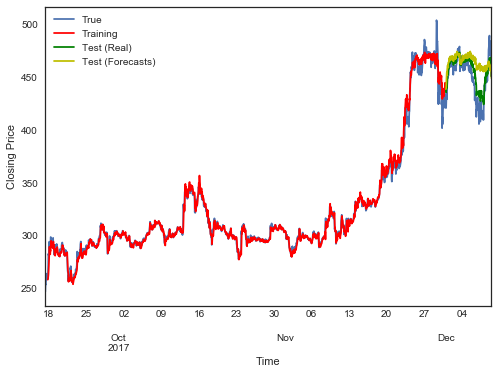

In [9]:
# Display results.
fig, ax = plt.subplots(1,1)
_ = sub_df['close'].plot(label='True', ax=ax)
_ = tr_pred_df[tr_pred_df.columns[0]].plot(label='Training', c='r', ax=ax)
_ = te_real_pred_df[te_real_pred_df.columns[0]].plot(label='Test (One Step Ahead)', c='g', ax=ax)
_ = te_fcast_pred_df[te_fcast_pred_df.columns[0]].plot(label='Test (Dynamic)', c='y', ax=ax)
_ = plt.xlabel('Time')
_ = plt.ylabel('Closing Price')
_ = plt.legend(loc='best')
plt.show()

### Forecasting with Differenced Closing Prices 

Note: We take the first difference, as that yields a stationary closing price for each cryptocurrency. 

In [10]:
# Difference closing prices (only variable that needs to be differenced for stationarity).
top_rows = df.iloc[0:13,:] # save for later
copy_df = df.copy()
close_cols = [x for x in df.columns if 'close' in x]
copy_df[close_cols] = copy_df[close_cols].diff()
copy_df = copy_df.drop(copy_df.index[0]) 

In [11]:
train_end = pd.to_datetime('2017/11/30 12:00:00')
test_start = pd.to_datetime('2017/11/30 13:00:00')
crypto_str = 'ETH_USD'

sub_df = copy_df.xs(crypto_str, level='fsym_tsym', axis=1)
tr_samples, te_samples, tr_outputs, te_outputs, tr_scl, tr_m, tr_v = prepare_samples(sub_df, 12, train_end)
train_df = sub_df.ix[:train_end]
test_df = sub_df.ix[test_start:] 
scl_test_df = pd.DataFrame(tr_scl.transform(test_df), columns=sub_df.columns).set_index(test_df.index)

In [12]:
np.random.seed(42)

# If model has already been trained/saved, load it back in instead of re-training.
model_name = 'lstm_stationary_saved.h5'
if os.path.isfile(model_name):
    model = load_model(model_name)
else:
    # Initialize LSTM.
    model = build_model(tr_samples, [20,20,1])
    
    # Train LSTM on training samples, storing information about training in tr_history.
    tr_history = model.fit(tr_samples, tr_outputs, epochs=1, batch_size=1, verbose=1, shuffle=True)
    model.save('lstm_stationary_saved.h5')

In [13]:
# Generate predictions for training set.
tr_predictions = model.predict(tr_samples)
tr_rescaled_preds = tr_predictions * math.sqrt(tr_v) + tr_m
train_dates = copy_df.index[12:1793]
tr_pred_df = pd.DataFrame(tr_rescaled_preds, index=train_dates)

# Generate predictions for test set.
te_predictions = pred_test_set(model, scl_test_df, 12, tr_m, tr_v, wreal=False)
test_dates = copy_df.index[-205:]
#te_rescaled_outputs = te_outputs * math.sqrt(tr_v) + tr_m
te_pred_df = pd.DataFrame(te_predictions, index=test_dates)

In [14]:
# Move from differences back to original time series (closing prices).
# NOTE: Only run this once (performing operations on original dataframe).
topr_sub_df = top_rows.xs(crypto_str, level='fsym_tsym', axis=1)
topr_closing_prices = topr_sub_df.close
starting_price = topr_closing_prices.iloc[-1]

for i in range(len(tr_pred_df.index)):
    if i == 0:
        tr_pred_df.iloc[i] += starting_price
    else:
        tr_pred_df.iloc[i] += tr_pred_df.iloc[i-1]
        
test_starting_price = tr_pred_df.iloc[-1]

for i in range(len(te_pred_df.index)):
    if i == 0:
        te_pred_df.iloc[i] += test_starting_price
    else:
        te_pred_df.iloc[i] += te_pred_df.iloc[i-1]

In [15]:
tr_pred_df.columns = ['close']
te_pred_df.columns = ['close']

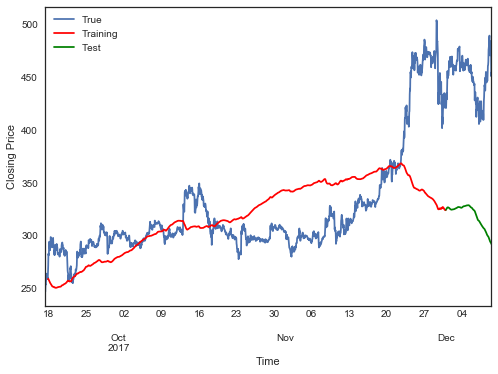

In [16]:
# Display results (BAD).
sub_df = df.xs(crypto_str, level='fsym_tsym', axis=1)

fig, ax = plt.subplots(1,1)
_ = sub_df['close'].plot(label='True', ax=ax)
_ = tr_pred_df[tr_pred_df.columns[0]].plot(label='Training', c='r', ax=ax)
_ = te_pred_df[te_pred_df.columns[0]].plot(label='Test', c='g', ax=ax)
_ = plt.xlabel('Time')
_ = plt.ylabel('Closing Price')
_ = plt.legend(loc='best')
plt.show()

Poor results, indicating that I may have made a boo boo somewhere down the line with my code.